In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-09-11 09:43:54--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2020-09-11 09:43:55 (48.0 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



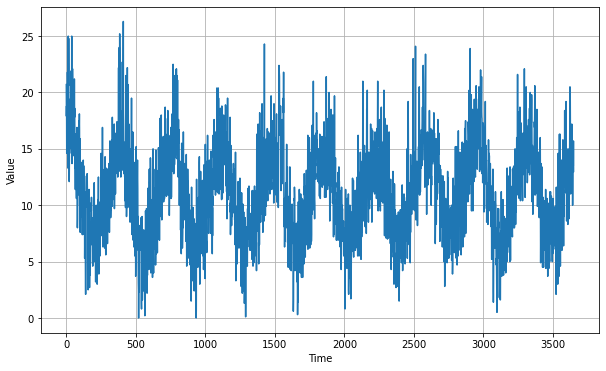

In [5]:
#Reading the csv files and creating a numpy array of time_steps and temperature values from csv file.

import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)  #Time step is the array of integer numbers 1, 2, 3....
    step += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
#Splitting the temperature values into training and validation using the time_split value

split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30 #Setting the window_size for single training examples
batch_size = 32 
shuffle_buffer_size = 1000


In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series,axis=-1)  #Expanding the dimension of series i.e. adding 1 to the dimension at last column
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True) #Applying window to the dataset
  ds = ds.flat_map(lambda w: w.batch(window_size + 1)) #Flattening the data set as rows
  ds = ds.shuffle(shuffle_buffer)  #Shuffling the dataset
  ds = ds.map(lambda w: (w[:-1],w[1:])) #Dividing the shuffled set to input(except last value of batch) and label(last value of batch)
  return ds.batch(batch_size).prefetch(1)

In [26]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast


In [25]:
tf.keras.backend.clear_session()  # Clear out all temporary variables that tf might have form previours sessions
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
      tf.keras.layers.LSTM(64,return_sequences=True),
      tf.keras.layers.LSTM(64,return_sequences=True),
      tf.keras.layers.Dense(30,activation='relu'),
      tf.keras.layers.Dense(10,activation='relu'),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 20ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 0s 26ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 0s 26ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

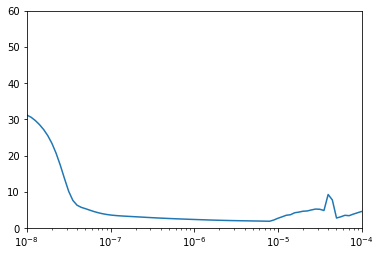

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=60,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
      tf.keras.layers.LSTM(60,return_sequences=True),
      tf.keras.layers.LSTM(60,return_sequences=True),
      tf.keras.layers.Dense(30,activation='relu'),
      tf.keras.layers.Dense(10,activation='relu'),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)
                                    


Epoch 1/100
25/25 [==============================] - 0s 15ms/step - loss: 9.9814 - mae: 10.4694
Epoch 2/100
25/25 [==============================] - 0s 15ms/step - loss: 2.5295 - mae: 2.9922
Epoch 3/100
25/25 [==============================] - 0s 14ms/step - loss: 1.9502 - mae: 2.4047
Epoch 4/100
25/25 [==============================] - 0s 15ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/100
25/25 [==============================] - 0s 14ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7909 - mae: 2.2418
Epoch 7/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/100
25/25 [==============================] - 0s 14ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/100
25/25 [==============================] - 0s 15ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/100
25/25 [============================

In [29]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

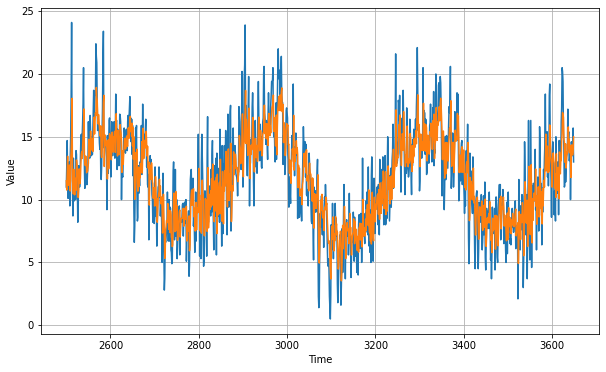

In [30]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [31]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()



1.78167

In [32]:
print(rnn_forecast)


[11.497884 10.762229 12.050677 ... 13.54856  13.746423 14.999531]
